In [1]:
import sys
sys.path.append('../')
from src.solvers.NN_random_solver import NN_random_solve
from src.solvers.gmres import mygmrestorch
from src.utils.physics import residue_E, src2rhs
from src.solvers.spins_solver import spins_solve
from src.utils.utils import *
from src.utils.plot_field3D import plot_3slices
from src.solvers.simulator import simulate, get_results, get_residual
import matplotlib.pyplot as plt
import numpy as np
import yaml
import time
import gc
import gin

original_sys_path = sys.path.copy()

In [2]:
###### (1) meta-atom model (PML in z only)
# model_path = '/media/ps3/chenkaim/checkpoints/copied_models/meta_atom_CondConv-10_11_25T03_44_51'

###### (2) aperiodic model (PML on all sides)
# model_path = '/media/ps3/chenkaim/checkpoints/copied_models/aperiodic_CondConv-10_11_25T06_03_52'
model_path = '/media/ps3/chenkaim/checkpoints/copied_models/aperiodic_CondConv_30_pml_small-10_16_25T15_21_04'

In [3]:
# prepare the model
sys.path = original_sys_path
sys.path.append(model_path)
for file in os.listdir(model_path):
    if file.endswith(".gin"):
        gin.parse_config_file(os.path.join(model_path, file))

# use the dummy trainer and ds to reproduce the feature engineering for eps (this part should be rewritten to be cleaner)
from waveynet3d.data.simulation_dataset import SyntheticDataset_same_wl_dL_shape as dataset_fn
from waveynet3d.trainers.iterative_trainer import IterativeTrainer as trainer_fn
dummy_trainer = trainer_fn(model_config=None, model_saving_path=None)
dummy_ds = dataset_fn(dummy_trainer.domain_sizes, dummy_trainer.pml_ranges, residual_type=dummy_trainer.residual_type)
dummy_ds.set_ln_R(dummy_trainer.ln_R)

from waveynet3d.models import model_factory as model_fn
model = prepare_model(dummy_trainer.domain_sizes, model_path, model_fn)

ds_loader = torch.utils.data.DataLoader(
    dataset=dummy_ds,
    batch_size=1,
    shuffle=False,
    num_workers=0,
    pin_memory=True,
    collate_fn=dummy_ds.collate_fn_same_wl_dL
)

test_GMRES_recurrence: 20
residual_clip: 10
synthetic dataset with pml_ranges: [30, 30, 30, 30, 30, 30]
PML: setting ln_R to -10


In [4]:
# prepare a random data from the dataloader
ith_data = 1
ds_iter = iter(ds_loader)
for i in range(ith_data):
    sample = next(ds_iter)
eps, src, dL, wl, pmls = sample['eps'].cuda(), sample['source'].cuda(), sample['dL'], sample['wl'], sample['pmls']
print('shape: ', eps.shape, 'wl: ', wl, 'dL: ', dL, 'pmls: ', pmls)

shape:  torch.Size([1, 175, 245, 96, 4]) wl:  tensor([800]) dL:  tensor([19.0476]) pmls:  tensor([[30, 30, 30, 30, 30, 30]])


# GMRES

In [5]:
tol = 1e-8
max_iter = 300
restart = 25
verbose= True

Aop = lambda x: r2c(residue_E(c2r(x), eps[...,0].to(torch.float64), src.to(torch.float64), pmls, dL[0].to(torch.float64).numpy(), wl[0].to(torch.float64).numpy(), batched_compute=True, Aop=True))
residual_fn = lambda x: r2c(residue_E(c2r(x), eps[...,0].to(torch.float64), src.to(torch.float64), pmls, dL[0].to(torch.float64).numpy(), wl[0].to(torch.float64).numpy(), batched_compute=True, Aop=False))
gmres = mygmrestorch(model, Aop, tol=tol, max_iter=max_iter)

In [6]:
# solve the problem:
complex_rhs = r2c(src2rhs(src, dL, wl))
start_time = time.time()
gmres.setup_eps(eps, dL/wl)
if restart == 0:
    x, history, _, _ = gmres.solve(complex_rhs, verbose)
else:
    x, history = gmres.solve_with_restart(complex_rhs, tol, max_iter, restart, verbose)
end_time = time.time()
NN_time = end_time-start_time
final_residual = residual_fn(x)
print("time take for NN solve: ", NN_time)

time take for NN solve:  28.476173639297485


# Spins verification

In [7]:
simulate(
    float(wl[0].numpy()),
    float(dL[0].numpy()),
    eps[0,...,0].detach().cpu(),
    src[0].detach().cpu(),
    pmls,
    proj_folder='../spins_files/',
    output_data_folder='../spins_files/',
    res_th = tol,
    max_iters = 40000
)

[2025-10-25 12:00:57,728][INFO][solver][run_plan] Setting up workspace.
[2025-10-25 12:00:57,730][INFO][solver][run_plan] Running transformation opt_cont.


MaxwellSolver with ln_R =  -10 m =  4 residual threshold =  1e-08 max iterations =  40000
file_prefix:  /tmp/tmp5822ljiv/maxwell-20251025-120122-ff5a1856-b1d4-11f0-911e-a0423f601cb4.E_x
file_prefix:  /tmp/tmp5822ljiv/maxwell-20251025-120122-ff5a1856-b1d4-11f0-911e-a0423f601cb4.E_y
file_prefix:  /tmp/tmp5822ljiv/maxwell-20251025-120122-ff5a1856-b1d4-11f0-911e-a0423f601cb4.E_z
Store output files


[2025-10-25 12:03:41,736][INFO][solver][run_plan] Spins finished.


solve_time: 121.33368682861328
iterations finished: 11275, final error: 7.698922e-09
run time for run_plan:  164.01153659820557


In [8]:
E_spins = get_results(store_dir='../spins_files/', eth=tol)
spins_residual = residual_fn(r2c(E_spins[None].cuda()))

In [9]:
eps.shape, src.shape, E_spins.shape

(torch.Size([1, 175, 245, 96, 4]),
 torch.Size([1, 175, 245, 96, 6]),
 torch.Size([175, 245, 96, 6]))

In [10]:
rel_diff, E_diff = scaled_MAE(c2r(x).cpu(), E_spins)
print("relative error between E_spin and E_model", rel_diff)

relative error between E_spin and E_model tensor(1.1797e-07, dtype=torch.float64)


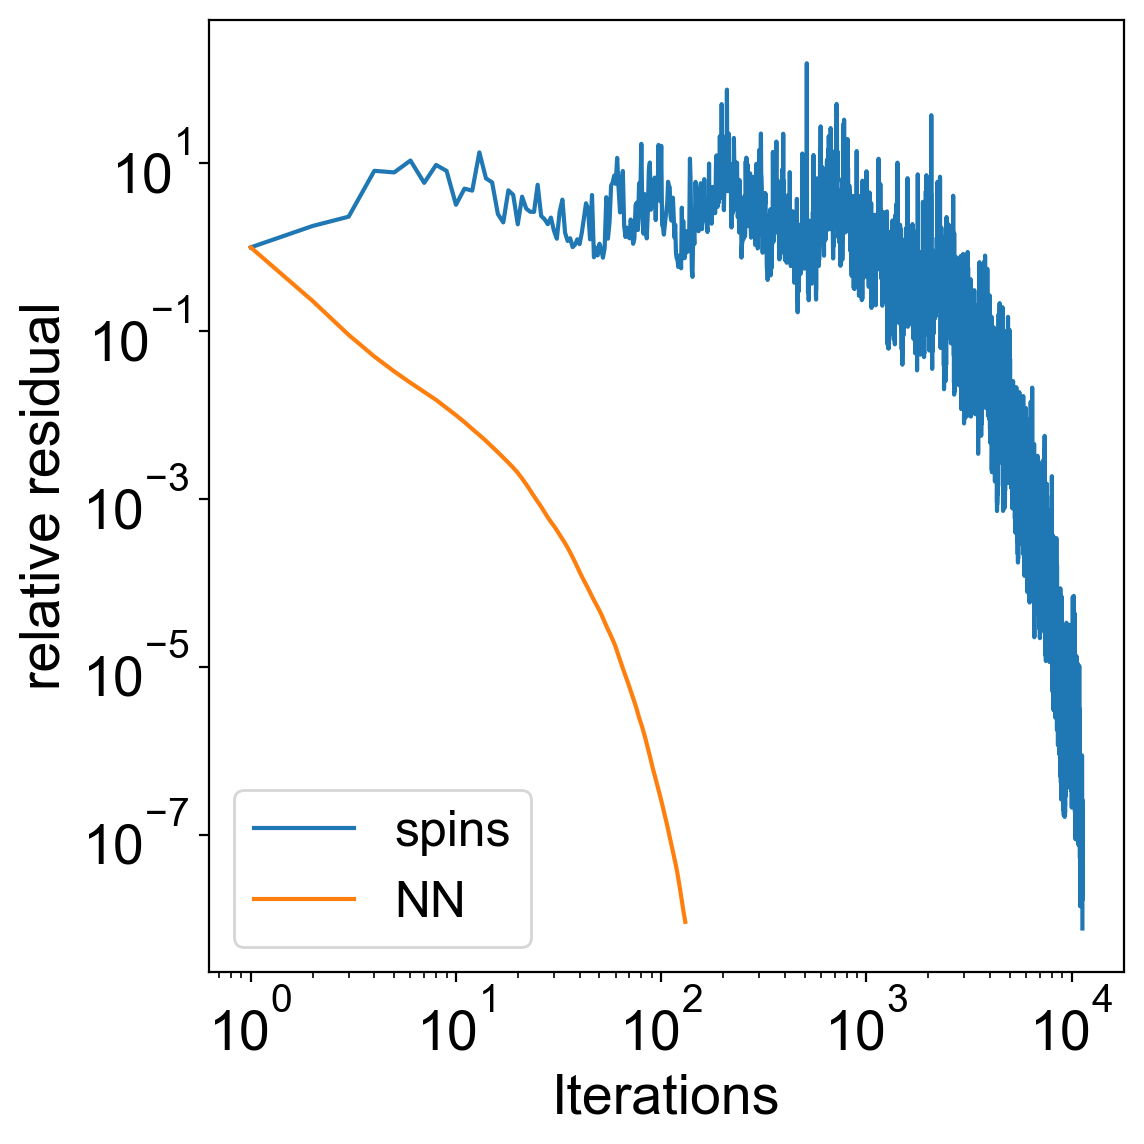

In [14]:
plt.rcParams.update({
    'font.size': 16,               # Default font size
    'font.sans-serif': ['Arial'],  # Specific font for sans-serif
    'axes.titlesize': 24,             # Font size for axes titles
    'axes.labelsize': 20,             # Font size for x and y labels
    'xtick.labelsize': 20,            # Font size for x-axis tick labels
    'ytick.labelsize': 20,            # Font size for y-axis tick labels
    'legend.fontsize': 18,            # Font size for legend
})

spins_time, residuals = get_residual(store_dir='../spins_files/')
iterations_spins = [i+1 for i in range(len(residuals))]
iterations_NN = [i+1 for i in range(len(history))]
plt.figure(figsize=(6,6), dpi=200)
plt.plot(iterations_spins, residuals, label = "spins")
plt.plot(iterations_NN, np.array(history), label = "NN")
# plt.title(f"time: {spins_time:.2f}s")
plt.yscale("log")
plt.xscale("log")
plt.ylabel("relative residual")
plt.xlabel("Iterations")
plt.legend()
plt.tight_layout()
plt.savefig("data/iteration_plot.png", dpi=200, transparent=True)

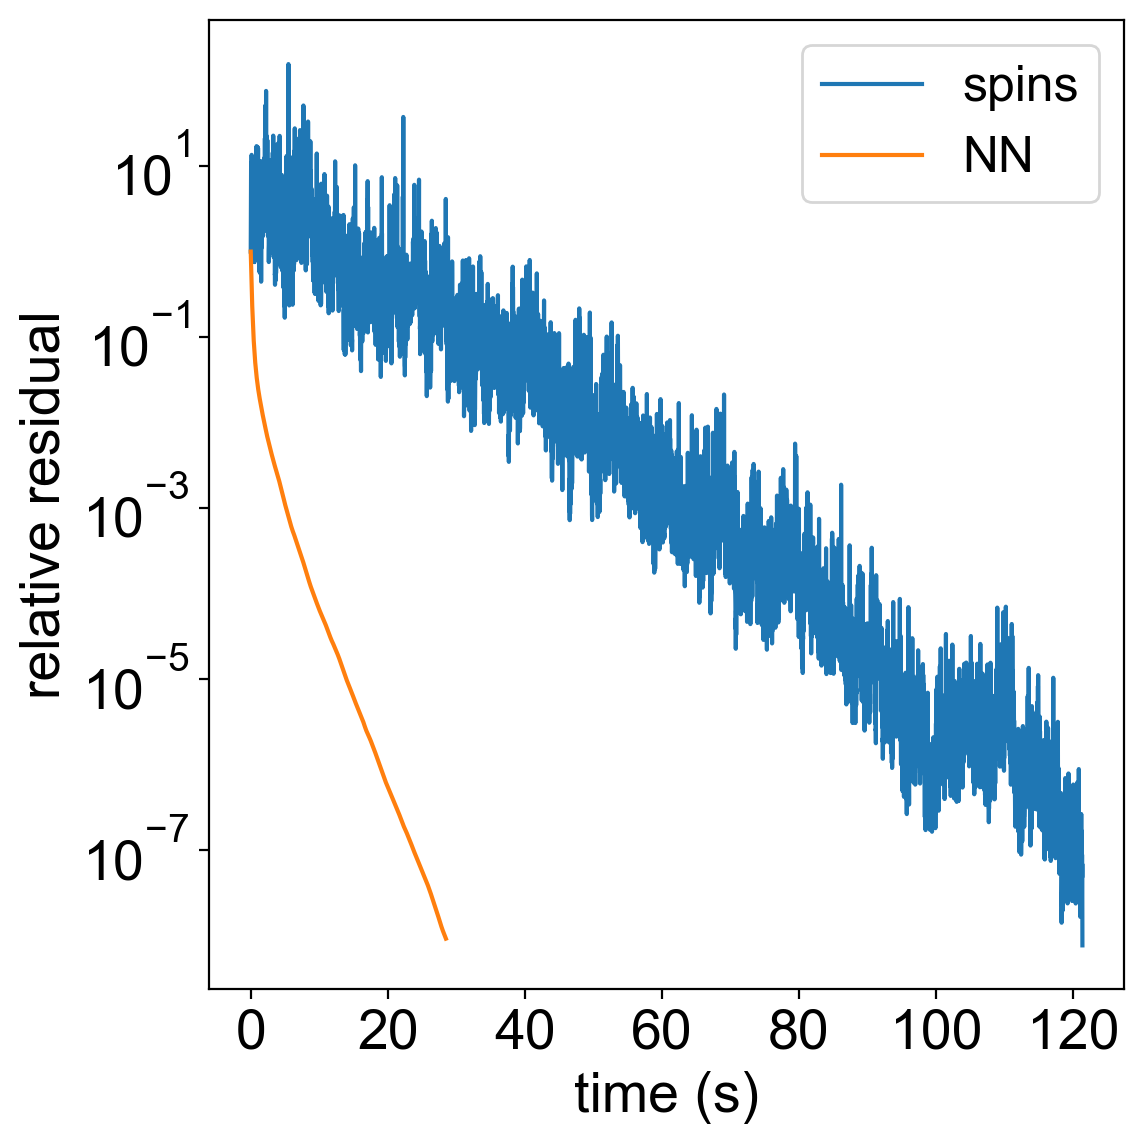

In [17]:
time_spins = [i/(len(residuals)-1) * spins_time for i in range(len(residuals))]
time_NN = [i/(len(history)-1) * NN_time for i in range(len(history))]
plt.figure(figsize=(6,6), dpi=200)
plt.plot(time_spins, residuals, label = "spins")
plt.plot(time_NN, np.array(history), label = "NN")
# plt.title(f"time: {spins_time:.2f}s")
plt.yscale("log")
# plt.xscale("log")
plt.ylabel("relative residual")
plt.xticks([0,20,40,60,80,100,120])
plt.xlabel("time (s)")
plt.legend()
plt.tight_layout()
plt.savefig("data/time_plot.png", dpi=200, transparent=True)

# Visualization

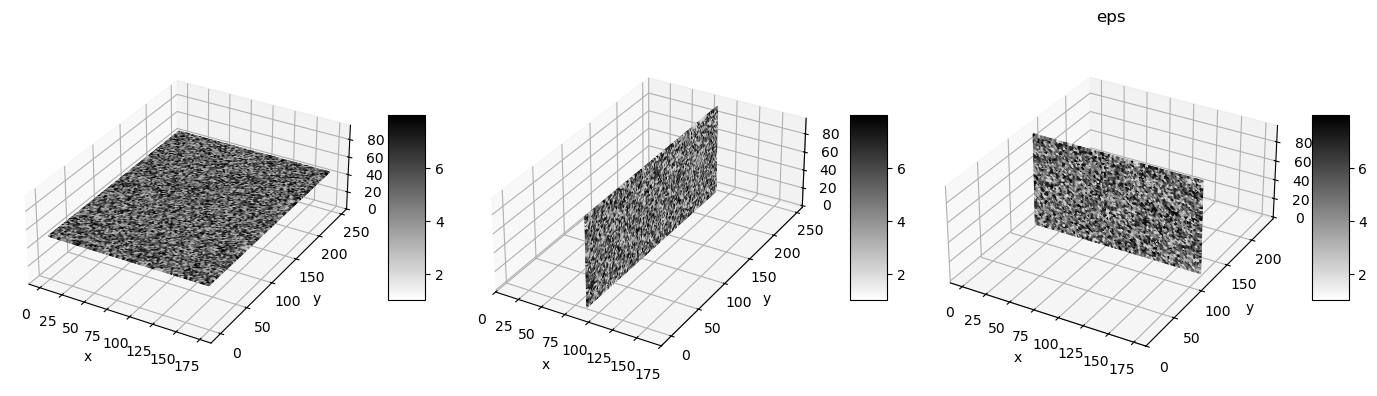

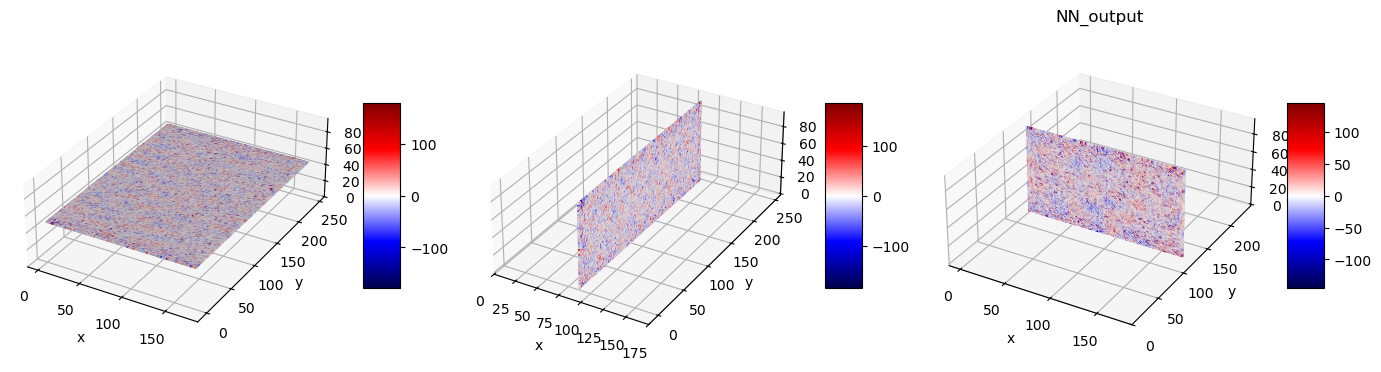

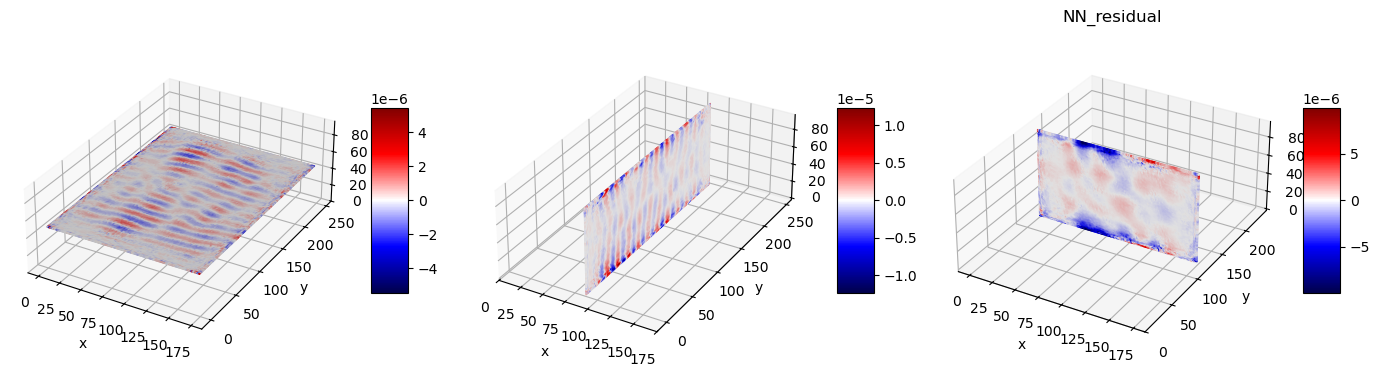

In [18]:
fig1 = plot_3slices(eps[0,:,:,:,0].detach().cpu().numpy().real, fname=None, my_cmap=plt.cm.binary, cm_zero_center=False, title="eps")
fig2 = plot_3slices(x[0,:,:,:,0].detach().cpu().numpy().real, fname=None, my_cmap=plt.cm.seismic, title="NN_output")
fig3 = plot_3slices(final_residual[0,:,:,:,0].detach().cpu().numpy().real, fname=None, my_cmap=plt.cm.seismic, title="NN_residual")

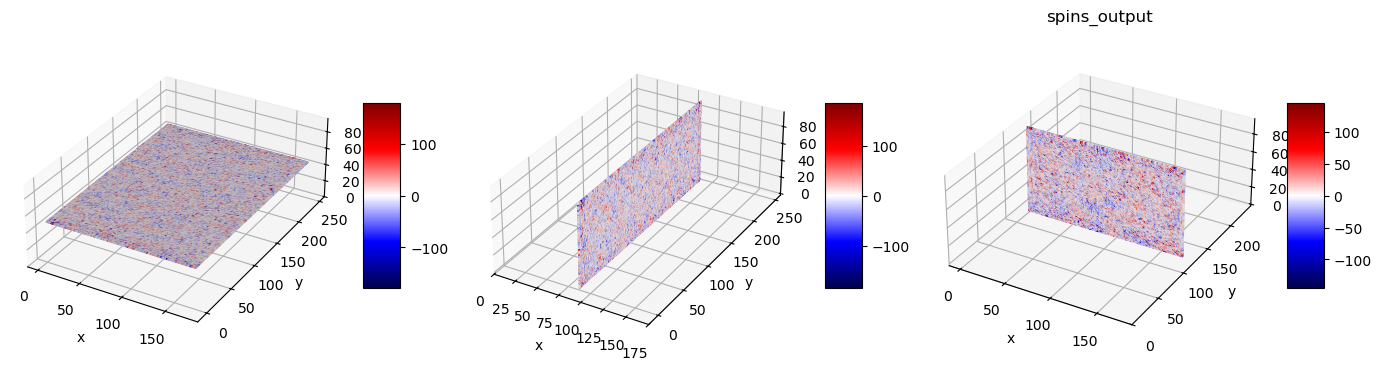

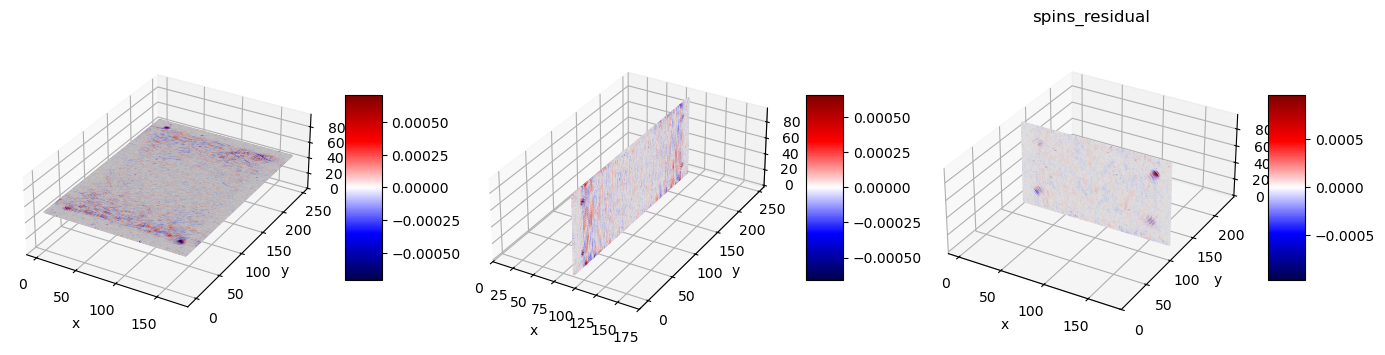

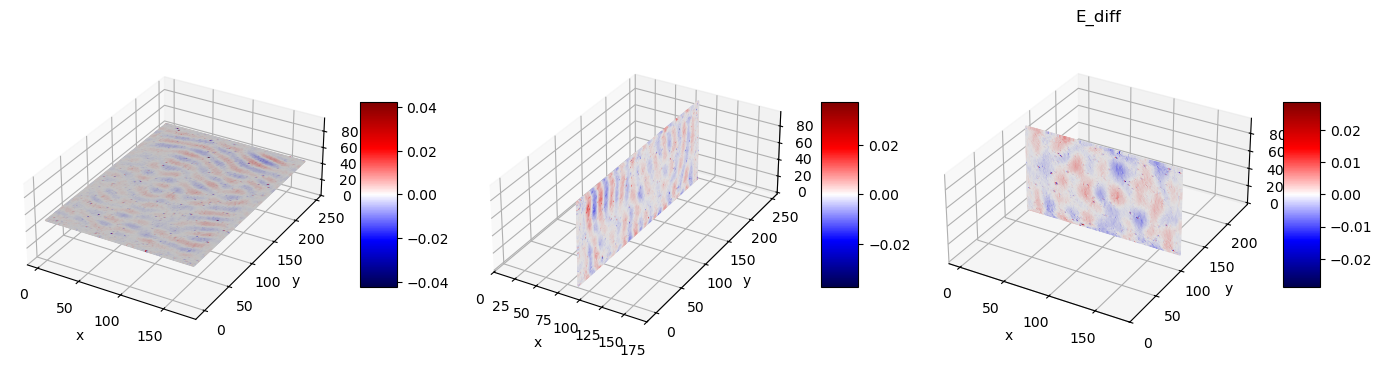

In [19]:
diff = E_spins[:,:,:,0].detach().cpu().numpy().real - x[0,:,:,:,0].detach().cpu().numpy().real
fig4 = plot_3slices(E_spins[:,:,:,0].detach().cpu().numpy().real, fname=None, my_cmap=plt.cm.seismic, title="spins_output")
fig5 = plot_3slices(spins_residual[0,:,:,:,0].detach().cpu().numpy().real, fname=None, my_cmap=plt.cm.seismic, title="spins_residual")
fig6 = plot_3slices(diff, fname=None, my_cmap=plt.cm.seismic, title="E_diff")

In [21]:
print("final_residual: \nNN: ", f"{torch.mean(torch.abs(final_residual)).item():.3e}", "\nspins: ", f"{torch.mean(torch.abs(spins_residual)).item():.3e}")

final_residual: 
NN:  7.324e-07 
spins:  6.365e-05


In [11]:
print("final residual NN: ", torch.mean(torch.abs(final_residual)))
print("final residual spins: ", torch.mean(torch.abs(spins_residual)))

final residual NN:  tensor(7.1672e-09, device='cuda:0', dtype=torch.float64)
final residual spins:  tensor(9.6405e-07, device='cuda:0', dtype=torch.float64)


# sweep for k data

In [4]:
def simulate_one_data(ith_data):
    # prepare a random data from the dataloader
    ds_iter = iter(ds_loader)
    for i in range(ith_data+1):
        sample = next(ds_iter)
    eps, src, dL, wl, pmls = sample['eps'].cuda(), sample['source'].cuda(), sample['dL'], sample['wl'], sample['pmls']
    num_voxels = np.prod(eps.shape)
    print('shape: ', eps.shape, 'num_voxels: ', num_voxels, 'wl: ', wl, 'dL: ', dL, 'pmls: ', pmls)

    ############# NN - GMRES ###############
    tol = 1e-4
    max_iter = 300
    restart = 25
    verbose= True
    
    Aop = lambda x: r2c(residue_E(c2r(x), eps[...,0].to(torch.float64), src.to(torch.float64), pmls, dL[0].to(torch.float64).numpy(), wl[0].to(torch.float64).numpy(), batched_compute=True, Aop=True))
    residual_fn = lambda x: r2c(residue_E(c2r(x), eps[...,0].to(torch.float64), src.to(torch.float64), pmls, dL[0].to(torch.float64).numpy(), wl[0].to(torch.float64).numpy(), batched_compute=True, Aop=False))
    gmres = mygmrestorch(model, Aop, tol=tol, max_iter=max_iter)

    complex_rhs = r2c(src2rhs(src, dL, wl))
    start_time = time.time()
    gmres.setup_eps(eps, dL/wl)
    if restart == 0:
        x, history, _, _ = gmres.solve(complex_rhs, verbose)
    else:
        x, history = gmres.solve_with_restart(complex_rhs, tol, max_iter, restart, verbose)
    end_time = time.time()
    NN_time = end_time-start_time
    final_residual = residual_fn(x)
    print("time take for NN solve: ", NN_time)

    del x, history, gmres
    torch.cuda.synchronize()
    torch.cuda.empty_cache()
    gc.collect()

    ############# spins bicg ###############
    simulate(
        float(wl[0].numpy()),
        float(dL[0].numpy()),
        eps[0,...,0].detach().cpu(),
        src[0].detach().cpu(),
        pmls,
        proj_folder='../spins_files/',
        output_data_folder='../spins_files/',
        res_th = 1e-4,
        max_iters = 40000
    )

    E_spins = get_results(store_dir='../spins_files/')
    spins_residual = residual_fn(r2c(E_spins[None].cuda()))
    spins_time, residuals = get_residual(store_dir='../spins_files/')
    print("time take for spins solve: ", spins_time)
    
    return num_voxels, NN_time, spins_time, final_residual, residuals[-1]

In [5]:
voxels = []
NN_times = []
spins_times = []
for i in range(15,50):
    num_voxels, NN_time, spins_time, _, _ = simulate_one_data(i)
    voxels.append(num_voxels)
    NN_times.append(NN_time)
    spins_times.append(spins_time)

    torch.cuda.synchronize()
    torch.cuda.empty_cache()
    gc.collect()

shape:  torch.Size([1, 247, 256, 124, 4]) num_voxels:  31363072 wl:  tensor([800]) dL:  tensor([21.0526]) pmls:  tensor([[30, 30, 30, 30, 30, 30]])


time take for NN solve:  15.089347124099731


[2025-10-24 20:44:26,785][INFO][solver][run_plan] Setting up workspace.
[2025-10-24 20:44:26,786][INFO][solver][run_plan] Running transformation opt_cont.


MaxwellSolver with ln_R =  -10 m =  4 residual threshold =  0.0001 max iterations =  40000
file_prefix:  /tmp/tmppv86nfxk/maxwell-20251024-204514-03f2267c-b155-11f0-9c87-a0423f601cb4.E_x
file_prefix:  /tmp/tmppv86nfxk/maxwell-20251024-204514-03f2267c-b155-11f0-9c87-a0423f601cb4.E_y
file_prefix:  /tmp/tmppv86nfxk/maxwell-20251024-204514-03f2267c-b155-11f0-9c87-a0423f601cb4.E_z
Store output files


[2025-10-24 20:47:09,324][INFO][solver][run_plan] Spins finished.


solve_time: 85.21751403808594
iterations finished: 4037, final error: 9.680137e-05
run time for run_plan:  162.54842615127563
time take for spins solve:  85.21751403808594
shape:  torch.Size([1, 249, 197, 97, 4]) num_voxels:  19032564 wl:  tensor([800]) dL:  tensor([20.5128]) pmls:  tensor([[30, 30, 30, 30, 30, 30]])


time take for NN solve:  10.740802764892578


[2025-10-24 20:48:09,629][INFO][solver][run_plan] Setting up workspace.
[2025-10-24 20:48:09,630][INFO][solver][run_plan] Running transformation opt_cont.


MaxwellSolver with ln_R =  -10 m =  4 residual threshold =  0.0001 max iterations =  40000
file_prefix:  /tmp/tmp3dnsv7kd/maxwell-20251024-204837-7d182510-b155-11f0-8a9d-a0423f601cb4.E_x
file_prefix:  /tmp/tmp3dnsv7kd/maxwell-20251024-204837-7d182510-b155-11f0-8a9d-a0423f601cb4.E_y
file_prefix:  /tmp/tmp3dnsv7kd/maxwell-20251024-204837-7d182510-b155-11f0-8a9d-a0423f601cb4.E_z
Store output files


[2025-10-24 20:50:17,397][INFO][solver][run_plan] Spins finished.


solve_time: 79.74091339111328
iterations finished: 6193, final error: 9.825052e-05
run time for run_plan:  127.77264475822449
time take for spins solve:  79.74091339111328
shape:  torch.Size([1, 185, 150, 127, 4]) num_voxels:  14097000 wl:  tensor([800]) dL:  tensor([17.7778]) pmls:  tensor([[30, 30, 30, 30, 30, 30]])


time take for NN solve:  7.956708192825317


[2025-10-24 20:51:17,114][INFO][solver][run_plan] Setting up workspace.
[2025-10-24 20:51:17,115][INFO][solver][run_plan] Running transformation opt_cont.


MaxwellSolver with ln_R =  -10 m =  4 residual threshold =  0.0001 max iterations =  40000
file_prefix:  /tmp/tmptdf7rb7y/maxwell-20251024-205136-e7b97694-b155-11f0-9618-a0423f601cb4.E_x
file_prefix:  /tmp/tmptdf7rb7y/maxwell-20251024-205136-e7b97694-b155-11f0-9618-a0423f601cb4.E_y
file_prefix:  /tmp/tmptdf7rb7y/maxwell-20251024-205136-e7b97694-b155-11f0-9618-a0423f601cb4.E_z
Store output files


[2025-10-24 20:52:39,997][INFO][solver][run_plan] Spins finished.


solve_time: 46.24293518066406
iterations finished: 4752, final error: 8.950584e-05
run time for run_plan:  82.89138960838318
time take for spins solve:  46.24293518066406
shape:  torch.Size([1, 147, 248, 101, 4]) num_voxels:  14728224 wl:  tensor([800]) dL:  tensor([20.]) pmls:  tensor([[30, 30, 30, 30, 30, 30]])


time take for NN solve:  6.933944940567017


[2025-10-24 20:53:39,498][INFO][solver][run_plan] Setting up workspace.
[2025-10-24 20:53:39,499][INFO][solver][run_plan] Running transformation opt_cont.


MaxwellSolver with ln_R =  -10 m =  4 residual threshold =  0.0001 max iterations =  40000
file_prefix:  /tmp/tmps2onam98/maxwell-20251024-205400-3d9a4804-b156-11f0-9ea1-a0423f601cb4.E_x
file_prefix:  /tmp/tmps2onam98/maxwell-20251024-205400-3d9a4804-b156-11f0-9ea1-a0423f601cb4.E_y
file_prefix:  /tmp/tmps2onam98/maxwell-20251024-205400-3d9a4804-b156-11f0-9ea1-a0423f601cb4.E_z
Store output files


[2025-10-24 20:55:02,087][INFO][solver][run_plan] Spins finished.


solve_time: 44.23554992675781
iterations finished: 4448, final error: 8.948194e-05
run time for run_plan:  82.59354424476624
time take for spins solve:  44.23554992675781
shape:  torch.Size([1, 238, 226, 115, 4]) num_voxels:  24742480 wl:  tensor([800]) dL:  tensor([13.5593]) pmls:  tensor([[30, 30, 30, 30, 30, 30]])


time take for NN solve:  21.278993368148804


[2025-10-24 20:56:23,003][INFO][solver][run_plan] Setting up workspace.
[2025-10-24 20:56:23,005][INFO][solver][run_plan] Running transformation opt_cont.


MaxwellSolver with ln_R =  -10 m =  4 residual threshold =  0.0001 max iterations =  40000
file_prefix:  /tmp/tmprbq9w531/maxwell-20251024-205700-a87fb67c-b156-11f0-b4ff-a0423f601cb4.E_x
file_prefix:  /tmp/tmprbq9w531/maxwell-20251024-205700-a87fb67c-b156-11f0-b4ff-a0423f601cb4.E_y
file_prefix:  /tmp/tmprbq9w531/maxwell-20251024-205700-a87fb67c-b156-11f0-b4ff-a0423f601cb4.E_z
Store output files


[2025-10-24 21:00:20,457][INFO][solver][run_plan] Spins finished.


solve_time: 175.96914672851562
iterations finished: 10489, final error: 9.576404e-05
run time for run_plan:  237.4564492702484
time take for spins solve:  175.96914672851562
shape:  torch.Size([1, 143, 203, 118, 4]) num_voxels:  13701688 wl:  tensor([800]) dL:  tensor([24.2424]) pmls:  tensor([[30, 30, 30, 30, 30, 30]])


time take for NN solve:  6.248704195022583


[2025-10-24 21:01:25,969][INFO][solver][run_plan] Setting up workspace.
[2025-10-24 21:01:25,971][INFO][solver][run_plan] Running transformation opt_cont.


MaxwellSolver with ln_R =  -10 m =  4 residual threshold =  0.0001 max iterations =  40000
file_prefix:  /tmp/tmp5rwnpl4j/maxwell-20251024-210145-52bcea9c-b157-11f0-a092-a0423f601cb4.E_x
file_prefix:  /tmp/tmp5rwnpl4j/maxwell-20251024-210145-52bcea9c-b157-11f0-a092-a0423f601cb4.E_y
file_prefix:  /tmp/tmp5rwnpl4j/maxwell-20251024-210145-52bcea9c-b157-11f0-a092-a0423f601cb4.E_z
Store output files


[2025-10-24 21:02:34,098][INFO][solver][run_plan] Spins finished.


solve_time: 32.13374328613281
iterations finished: 3258, final error: 7.327452e-05
run time for run_plan:  68.13229441642761
time take for spins solve:  32.13374328613281
shape:  torch.Size([1, 184, 132, 106, 4]) num_voxels:  10298112 wl:  tensor([800]) dL:  tensor([20.5128]) pmls:  tensor([[30, 30, 30, 30, 30, 30]])


time take for NN solve:  4.657204866409302


[2025-10-24 21:03:39,313][INFO][solver][run_plan] Setting up workspace.
[2025-10-24 21:03:39,314][INFO][solver][run_plan] Running transformation opt_cont.


MaxwellSolver with ln_R =  -10 m =  4 residual threshold =  0.0001 max iterations =  40000
file_prefix:  /tmp/tmpeaq5g9mz/maxwell-20251024-210353-9f0db728-b157-11f0-9aab-a0423f601cb4.E_x
file_prefix:  /tmp/tmpeaq5g9mz/maxwell-20251024-210353-9f0db728-b157-11f0-9aab-a0423f601cb4.E_y
file_prefix:  /tmp/tmpeaq5g9mz/maxwell-20251024-210353-9f0db728-b157-11f0-9aab-a0423f601cb4.E_z
Store output files


[2025-10-24 21:04:39,774][INFO][solver][run_plan] Spins finished.


solve_time: 34.25517272949219
iterations finished: 4483, final error: 9.920493e-05
run time for run_plan:  60.463183641433716
time take for spins solve:  34.25517272949219
shape:  torch.Size([1, 172, 228, 116, 4]) num_voxels:  18196224 wl:  tensor([800]) dL:  tensor([15.6863]) pmls:  tensor([[30, 30, 30, 30, 30, 30]])


time take for NN solve:  9.963584661483765


[2025-10-24 21:05:52,049][INFO][solver][run_plan] Setting up workspace.
[2025-10-24 21:05:52,050][INFO][solver][run_plan] Running transformation opt_cont.


MaxwellSolver with ln_R =  -10 m =  4 residual threshold =  0.0001 max iterations =  40000
file_prefix:  /tmp/tmphljujf_e/maxwell-20251024-210619-f5c3f0be-b157-11f0-9939-a0423f601cb4.E_x
file_prefix:  /tmp/tmphljujf_e/maxwell-20251024-210619-f5c3f0be-b157-11f0-9939-a0423f601cb4.E_y
file_prefix:  /tmp/tmphljujf_e/maxwell-20251024-210619-f5c3f0be-b157-11f0-9939-a0423f601cb4.E_z
Store output files


[2025-10-24 21:07:45,506][INFO][solver][run_plan] Spins finished.


solve_time: 66.7037353515625
iterations finished: 5194, final error: 8.134928e-05
run time for run_plan:  113.45941185951233
time take for spins solve:  66.7037353515625
shape:  torch.Size([1, 168, 159, 108, 4]) num_voxels:  11539584 wl:  tensor([800]) dL:  tensor([16.3265]) pmls:  tensor([[30, 30, 30, 30, 30, 30]])


time take for NN solve:  6.612900972366333


[2025-10-24 21:08:54,955][INFO][solver][run_plan] Setting up workspace.
[2025-10-24 21:08:54,957][INFO][solver][run_plan] Running transformation opt_cont.


MaxwellSolver with ln_R =  -10 m =  4 residual threshold =  0.0001 max iterations =  40000
file_prefix:  /tmp/tmpfb7i5oaj/maxwell-20251024-210911-5c3cbfe2-b158-11f0-a306-a0423f601cb4.E_x
file_prefix:  /tmp/tmpfb7i5oaj/maxwell-20251024-210911-5c3cbfe2-b158-11f0-a306-a0423f601cb4.E_y
file_prefix:  /tmp/tmpfb7i5oaj/maxwell-20251024-210911-5c3cbfe2-b158-11f0-a306-a0423f601cb4.E_z
Store output files


[2025-10-24 21:10:08,970][INFO][solver][run_plan] Spins finished.


solve_time: 42.64341354370117
iterations finished: 4945, final error: 7.567847e-05
run time for run_plan:  74.01780557632446
time take for spins solve:  42.64341354370117
shape:  torch.Size([1, 215, 228, 111, 4]) num_voxels:  21764880 wl:  tensor([800]) dL:  tensor([25.]) pmls:  tensor([[30, 30, 30, 30, 30, 30]])


time take for NN solve:  10.306084394454956


[2025-10-24 21:11:25,192][INFO][solver][run_plan] Setting up workspace.
[2025-10-24 21:11:25,194][INFO][solver][run_plan] Running transformation opt_cont.


MaxwellSolver with ln_R =  -10 m =  4 residual threshold =  0.0001 max iterations =  40000
file_prefix:  /tmp/tmpch8vb_oi/maxwell-20251024-211157-bf7eebd4-b158-11f0-a0ba-a0423f601cb4.E_x
file_prefix:  /tmp/tmpch8vb_oi/maxwell-20251024-211157-bf7eebd4-b158-11f0-a0ba-a0423f601cb4.E_y
file_prefix:  /tmp/tmpch8vb_oi/maxwell-20251024-211157-bf7eebd4-b158-11f0-a0ba-a0423f601cb4.E_z
Store output files


[2025-10-24 21:13:30,773][INFO][solver][run_plan] Spins finished.


solve_time: 69.95532989501953
iterations finished: 4918, final error: 6.770469e-05
run time for run_plan:  125.58298873901367
time take for spins solve:  69.95532989501953
shape:  torch.Size([1, 190, 189, 119, 4]) num_voxels:  17093160 wl:  tensor([800]) dL:  tensor([23.5294]) pmls:  tensor([[30, 30, 30, 30, 30, 30]])


time take for NN solve:  8.127436876296997


[2025-10-24 21:14:50,909][INFO][solver][run_plan] Setting up workspace.
[2025-10-24 21:14:50,910][INFO][solver][run_plan] Running transformation opt_cont.


MaxwellSolver with ln_R =  -10 m =  4 residual threshold =  0.0001 max iterations =  40000
file_prefix:  /tmp/tmpzaaq14kx/maxwell-20251024-211516-35df9ac6-b159-11f0-a1a2-a0423f601cb4.E_x
file_prefix:  /tmp/tmpzaaq14kx/maxwell-20251024-211516-35df9ac6-b159-11f0-a1a2-a0423f601cb4.E_y
file_prefix:  /tmp/tmpzaaq14kx/maxwell-20251024-211516-35df9ac6-b159-11f0-a1a2-a0423f601cb4.E_z
Store output files


[2025-10-24 21:16:28,985][INFO][solver][run_plan] Spins finished.


solve_time: 52.750572204589844
iterations finished: 4452, final error: 8.547678e-05
run time for run_plan:  98.07814359664917
time take for spins solve:  52.750572204589844
shape:  torch.Size([1, 190, 134, 97, 4]) num_voxels:  9878480 wl:  tensor([800]) dL:  tensor([15.6863]) pmls:  tensor([[30, 30, 30, 30, 30, 30]])


time take for NN solve:  6.061908721923828


[2025-10-24 21:17:47,833][INFO][solver][run_plan] Setting up workspace.
[2025-10-24 21:17:47,834][INFO][solver][run_plan] Running transformation opt_cont.


MaxwellSolver with ln_R =  -10 m =  4 residual threshold =  0.0001 max iterations =  40000
file_prefix:  /tmp/tmpyg64q3e9/maxwell-20251024-211801-98669cd0-b159-11f0-a44a-a0423f601cb4.E_x
file_prefix:  /tmp/tmpyg64q3e9/maxwell-20251024-211801-98669cd0-b159-11f0-a44a-a0423f601cb4.E_y
file_prefix:  /tmp/tmpyg64q3e9/maxwell-20251024-211801-98669cd0-b159-11f0-a44a-a0423f601cb4.E_z
Store output files


[2025-10-24 21:18:52,587][INFO][solver][run_plan] Spins finished.


solve_time: 38.856719970703125
iterations finished: 5056, final error: 7.607129e-05
run time for run_plan:  64.7621476650238
time take for spins solve:  38.856719970703125
shape:  torch.Size([1, 200, 159, 120, 4]) num_voxels:  15264000 wl:  tensor([800]) dL:  tensor([16.3265]) pmls:  tensor([[30, 30, 30, 30, 30, 30]])


time take for NN solve:  8.891137599945068


[2025-10-24 21:20:15,456][INFO][solver][run_plan] Setting up workspace.
[2025-10-24 21:20:15,458][INFO][solver][run_plan] Running transformation opt_cont.


MaxwellSolver with ln_R =  -10 m =  4 residual threshold =  0.0001 max iterations =  40000
file_prefix:  /tmp/tmp4rygy1he/maxwell-20251024-212037-f551b7b8-b159-11f0-bc32-a0423f601cb4.E_x
file_prefix:  /tmp/tmp4rygy1he/maxwell-20251024-212037-f551b7b8-b159-11f0-bc32-a0423f601cb4.E_y
file_prefix:  /tmp/tmp4rygy1he/maxwell-20251024-212037-f551b7b8-b159-11f0-bc32-a0423f601cb4.E_z
Store output files


[2025-10-24 21:21:57,494][INFO][solver][run_plan] Spins finished.


solve_time: 64.02104949951172
iterations finished: 6313, final error: 9.993145e-05
run time for run_plan:  102.04220676422119
time take for spins solve:  64.02104949951172
shape:  torch.Size([1, 133, 150, 128, 4]) num_voxels:  10214400 wl:  tensor([800]) dL:  tensor([25.8065]) pmls:  tensor([[30, 30, 30, 30, 30, 30]])


time take for NN solve:  5.322797536849976


[2025-10-24 21:23:18,478][INFO][solver][run_plan] Setting up workspace.
[2025-10-24 21:23:18,479][INFO][solver][run_plan] Running transformation opt_cont.


MaxwellSolver with ln_R =  -10 m =  4 residual threshold =  0.0001 max iterations =  40000
file_prefix:  /tmp/tmp3s5i350v/maxwell-20251024-212333-5e4ea352-b15a-11f0-9a54-a0423f601cb4.E_x
file_prefix:  /tmp/tmp3s5i350v/maxwell-20251024-212333-5e4ea352-b15a-11f0-9a54-a0423f601cb4.E_y
file_prefix:  /tmp/tmp3s5i350v/maxwell-20251024-212333-5e4ea352-b15a-11f0-9a54-a0423f601cb4.E_z
Store output files


[2025-10-24 21:24:19,704][INFO][solver][run_plan] Spins finished.


solve_time: 32.72381591796875
iterations finished: 4309, final error: 7.508262e-05
run time for run_plan:  61.23175930976868
time take for spins solve:  32.72381591796875
shape:  torch.Size([1, 243, 162, 128, 4]) num_voxels:  20155392 wl:  tensor([800]) dL:  tensor([15.6863]) pmls:  tensor([[30, 30, 30, 30, 30, 30]])


time take for NN solve:  11.062653064727783


[2025-10-24 21:25:48,108][INFO][solver][run_plan] Setting up workspace.
[2025-10-24 21:25:48,109][INFO][solver][run_plan] Running transformation opt_cont.


MaxwellSolver with ln_R =  -10 m =  4 residual threshold =  0.0001 max iterations =  40000
file_prefix:  /tmp/tmpzvtvkydg/maxwell-20251024-212619-c17db378-b15a-11f0-a25b-a0423f601cb4.E_x
file_prefix:  /tmp/tmpzvtvkydg/maxwell-20251024-212619-c17db378-b15a-11f0-a25b-a0423f601cb4.E_y
file_prefix:  /tmp/tmpzvtvkydg/maxwell-20251024-212619-c17db378-b15a-11f0-a25b-a0423f601cb4.E_z
Store output files


[2025-10-24 21:27:59,442][INFO][solver][run_plan] Spins finished.


solve_time: 76.58729553222656
iterations finished: 5731, final error: 8.39578e-05
run time for run_plan:  131.33674573898315
time take for spins solve:  76.58729553222656
shape:  torch.Size([1, 173, 181, 113, 4]) num_voxels:  14153476 wl:  tensor([800]) dL:  tensor([22.8571]) pmls:  tensor([[30, 30, 30, 30, 30, 30]])


time take for NN solve:  5.325203895568848


[2025-10-24 21:29:23,376][INFO][solver][run_plan] Setting up workspace.
[2025-10-24 21:29:23,378][INFO][solver][run_plan] Running transformation opt_cont.


MaxwellSolver with ln_R =  -10 m =  4 residual threshold =  0.0001 max iterations =  40000
file_prefix:  /tmp/tmp3cwvb4pm/maxwell-20251024-212943-3b13ef36-b15b-11f0-ac10-a0423f601cb4.E_x
file_prefix:  /tmp/tmp3cwvb4pm/maxwell-20251024-212943-3b13ef36-b15b-11f0-ac10-a0423f601cb4.E_y
file_prefix:  /tmp/tmp3cwvb4pm/maxwell-20251024-212943-3b13ef36-b15b-11f0-ac10-a0423f601cb4.E_z
Store output files


[2025-10-24 21:30:27,042][INFO][solver][run_plan] Spins finished.


solve_time: 28.47095489501953
iterations finished: 2727, final error: 9.629164e-05
run time for run_plan:  63.67099976539612
time take for spins solve:  28.47095489501953
shape:  torch.Size([1, 215, 144, 119, 4]) num_voxels:  14736960 wl:  tensor([800]) dL:  tensor([16.6667]) pmls:  tensor([[30, 30, 30, 30, 30, 30]])


time take for NN solve:  6.824151515960693


[2025-10-24 21:31:54,071][INFO][solver][run_plan] Setting up workspace.
[2025-10-24 21:31:54,072][INFO][solver][run_plan] Running transformation opt_cont.


MaxwellSolver with ln_R =  -10 m =  4 residual threshold =  0.0001 max iterations =  40000
file_prefix:  /tmp/tmpbe4u0px8/maxwell-20251024-213214-950b8968-b15b-11f0-a428-a0423f601cb4.E_x
file_prefix:  /tmp/tmpbe4u0px8/maxwell-20251024-213214-950b8968-b15b-11f0-a428-a0423f601cb4.E_y
file_prefix:  /tmp/tmpbe4u0px8/maxwell-20251024-213214-950b8968-b15b-11f0-a428-a0423f601cb4.E_z
Store output files


[2025-10-24 21:33:17,040][INFO][solver][run_plan] Spins finished.


solve_time: 45.63340759277344
iterations finished: 4546, final error: 5.793382e-05
run time for run_plan:  82.98070645332336
time take for spins solve:  45.63340759277344
shape:  torch.Size([1, 171, 182, 120, 4]) num_voxels:  14938560 wl:  tensor([800]) dL:  tensor([15.0943]) pmls:  tensor([[30, 30, 30, 30, 30, 30]])


time take for NN solve:  8.060287714004517


[2025-10-24 21:34:45,864][INFO][solver][run_plan] Setting up workspace.
[2025-10-24 21:34:45,865][INFO][solver][run_plan] Running transformation opt_cont.


MaxwellSolver with ln_R =  -10 m =  4 residual threshold =  0.0001 max iterations =  40000
file_prefix:  /tmp/tmp6sf88277/maxwell-20251024-213506-fb53bbdc-b15b-11f0-a3af-a0423f601cb4.E_x
file_prefix:  /tmp/tmp6sf88277/maxwell-20251024-213506-fb53bbdc-b15b-11f0-a3af-a0423f601cb4.E_y
file_prefix:  /tmp/tmp6sf88277/maxwell-20251024-213506-fb53bbdc-b15b-11f0-a3af-a0423f601cb4.E_z
Store output files


[2025-10-24 21:35:56,673][INFO][solver][run_plan] Spins finished.


solve_time: 34.266788482666016
iterations finished: 3171, final error: 7.988154e-05
run time for run_plan:  70.81264758110046
time take for spins solve:  34.266788482666016
shape:  torch.Size([1, 194, 185, 99, 4]) num_voxels:  14212440 wl:  tensor([800]) dL:  tensor([16.]) pmls:  tensor([[30, 30, 30, 30, 30, 30]])


time take for NN solve:  7.400717496871948


[2025-10-24 21:37:28,410][INFO][solver][run_plan] Setting up workspace.
[2025-10-24 21:37:28,411][INFO][solver][run_plan] Running transformation opt_cont.


MaxwellSolver with ln_R =  -10 m =  4 residual threshold =  0.0001 max iterations =  40000
file_prefix:  /tmp/tmpu_vcrku_/maxwell-20251024-213748-5bc829ee-b15c-11f0-b7ba-a0423f601cb4.E_x
file_prefix:  /tmp/tmpu_vcrku_/maxwell-20251024-213748-5bc829ee-b15c-11f0-b7ba-a0423f601cb4.E_y
file_prefix:  /tmp/tmpu_vcrku_/maxwell-20251024-213748-5bc829ee-b15c-11f0-b7ba-a0423f601cb4.E_z
Store output files


[2025-10-24 21:39:05,633][INFO][solver][run_plan] Spins finished.


solve_time: 61.779151916503906
iterations finished: 6222, final error: 9.571799e-05
run time for run_plan:  97.22934651374817
time take for spins solve:  61.779151916503906
shape:  torch.Size([1, 250, 233, 117, 4]) num_voxels:  27261000 wl:  tensor([800]) dL:  tensor([25.8065]) pmls:  tensor([[30, 30, 30, 30, 30, 30]])


time take for NN solve:  20.42425799369812


[2025-10-24 21:40:58,080][INFO][solver][run_plan] Setting up workspace.
[2025-10-24 21:40:58,082][INFO][solver][run_plan] Running transformation opt_cont.


MaxwellSolver with ln_R =  -10 m =  4 residual threshold =  0.0001 max iterations =  40000
file_prefix:  /tmp/tmp503wnbna/maxwell-20251024-214138-e4ca6c66-b15c-11f0-ae32-a0423f601cb4.E_x
file_prefix:  /tmp/tmp503wnbna/maxwell-20251024-214138-e4ca6c66-b15c-11f0-ae32-a0423f601cb4.E_y
file_prefix:  /tmp/tmp503wnbna/maxwell-20251024-214138-e4ca6c66-b15c-11f0-ae32-a0423f601cb4.E_z
Store output files


[2025-10-24 21:43:57,202][INFO][solver][run_plan] Spins finished.


solve_time: 111.3745346069336
iterations finished: 6092, final error: 9.866086e-05
run time for run_plan:  179.12480568885803
time take for spins solve:  111.3745346069336
shape:  torch.Size([1, 143, 161, 96, 4]) num_voxels:  8840832 wl:  tensor([800]) dL:  tensor([20.5128]) pmls:  tensor([[30, 30, 30, 30, 30, 30]])


[2025-10-24 21:45:33,321][INFO][solver][run_plan] Setting up workspace.                                                        
[2025-10-24 21:45:33,323][INFO][solver][run_plan] Running transformation opt_cont.


time take for NN solve:  4.224556922912598
MaxwellSolver with ln_R =  -10 m =  4 residual threshold =  0.0001 max iterations =  40000
file_prefix:  /tmp/tmphud16i63/maxwell-20251024-214545-785a3f42-b15d-11f0-97ff-a0423f601cb4.E_x
file_prefix:  /tmp/tmphud16i63/maxwell-20251024-214545-785a3f42-b15d-11f0-97ff-a0423f601cb4.E_y
file_prefix:  /tmp/tmphud16i63/maxwell-20251024-214545-785a3f42-b15d-11f0-97ff-a0423f601cb4.E_z
Store output files


[2025-10-24 21:46:23,438][INFO][solver][run_plan] Spins finished.


solve_time: 24.937040328979492
iterations finished: 3640, final error: 9.494829e-05
run time for run_plan:  50.11991834640503
time take for spins solve:  24.937040328979492
shape:  torch.Size([1, 226, 172, 105, 4]) num_voxels:  16326240 wl:  tensor([800]) dL:  tensor([22.8571]) pmls:  tensor([[30, 30, 30, 30, 30, 30]])


time take for NN solve:  9.303735971450806


[2025-10-24 21:48:07,627][INFO][solver][run_plan] Setting up workspace.
[2025-10-24 21:48:07,629][INFO][solver][run_plan] Running transformation opt_cont.


MaxwellSolver with ln_R =  -10 m =  4 residual threshold =  0.0001 max iterations =  40000
file_prefix:  /tmp/tmpo_k6e2r9/maxwell-20251024-214831-daeaf804-b15d-11f0-b56b-a0423f601cb4.E_x
file_prefix:  /tmp/tmpo_k6e2r9/maxwell-20251024-214831-daeaf804-b15d-11f0-b56b-a0423f601cb4.E_y
file_prefix:  /tmp/tmpo_k6e2r9/maxwell-20251024-214831-daeaf804-b15d-11f0-b56b-a0423f601cb4.E_z
Store output files


[2025-10-24 21:49:53,333][INFO][solver][run_plan] Spins finished.


solve_time: 63.882781982421875
iterations finished: 5450, final error: 9.689895e-05
run time for run_plan:  105.71444153785706
time take for spins solve:  63.882781982421875
shape:  torch.Size([1, 235, 204, 124, 4]) num_voxels:  23778240 wl:  tensor([800]) dL:  tensor([17.7778]) pmls:  tensor([[30, 30, 30, 30, 30, 30]])


time take for NN solve:  13.640565872192383


[2025-10-24 21:51:45,081][INFO][solver][run_plan] Setting up workspace.
[2025-10-24 21:51:45,083][INFO][solver][run_plan] Running transformation opt_cont.


MaxwellSolver with ln_R =  -10 m =  4 residual threshold =  0.0001 max iterations =  40000
file_prefix:  /tmp/tmpul71nyja/maxwell-20251024-215220-63900424-b15e-11f0-9dec-a0423f601cb4.E_x
file_prefix:  /tmp/tmpul71nyja/maxwell-20251024-215220-63900424-b15e-11f0-9dec-a0423f601cb4.E_y
file_prefix:  /tmp/tmpul71nyja/maxwell-20251024-215220-63900424-b15e-11f0-9dec-a0423f601cb4.E_z
Store output files


[2025-10-24 21:54:22,181][INFO][solver][run_plan] Spins finished.


solve_time: 98.1310043334961
iterations finished: 6368, final error: 6.830028e-05
run time for run_plan:  157.1027762889862
time take for spins solve:  98.1310043334961
shape:  torch.Size([1, 203, 181, 115, 4]) num_voxels:  16901780 wl:  tensor([800]) dL:  tensor([25.8065]) pmls:  tensor([[30, 30, 30, 30, 30, 30]])


time take for NN solve:  10.781011581420898


[2025-10-24 21:56:14,488][INFO][solver][run_plan] Setting up workspace.
[2025-10-24 21:56:14,489][INFO][solver][run_plan] Running transformation opt_cont.


MaxwellSolver with ln_R =  -10 m =  4 residual threshold =  0.0001 max iterations =  40000
file_prefix:  /tmp/tmppl1ptyr2/maxwell-20251024-215639-fe2dcea8-b15e-11f0-8aef-a0423f601cb4.E_x
file_prefix:  /tmp/tmppl1ptyr2/maxwell-20251024-215639-fe2dcea8-b15e-11f0-8aef-a0423f601cb4.E_y
file_prefix:  /tmp/tmppl1ptyr2/maxwell-20251024-215639-fe2dcea8-b15e-11f0-8aef-a0423f601cb4.E_z
Store output files


[2025-10-24 21:58:04,413][INFO][solver][run_plan] Spins finished.


solve_time: 65.06517028808594
iterations finished: 5634, final error: 8.028443e-05
run time for run_plan:  109.92759656906128
time take for spins solve:  65.06517028808594
shape:  torch.Size([1, 233, 169, 96, 4]) num_voxels:  15120768 wl:  tensor([800]) dL:  tensor([20.5128]) pmls:  tensor([[30, 30, 30, 30, 30, 30]])


time take for NN solve:  7.83841347694397


[2025-10-24 21:59:56,578][INFO][solver][run_plan] Setting up workspace.
[2025-10-24 21:59:56,580][INFO][solver][run_plan] Running transformation opt_cont.


MaxwellSolver with ln_R =  -10 m =  4 residual threshold =  0.0001 max iterations =  40000
file_prefix:  /tmp/tmpt5iubg1p/maxwell-20251024-220019-80e9cfa4-b15f-11f0-be0d-a0423f601cb4.E_x
file_prefix:  /tmp/tmpt5iubg1p/maxwell-20251024-220019-80e9cfa4-b15f-11f0-be0d-a0423f601cb4.E_y
file_prefix:  /tmp/tmpt5iubg1p/maxwell-20251024-220019-80e9cfa4-b15f-11f0-be0d-a0423f601cb4.E_z
Store output files


[2025-10-24 22:01:32,331][INFO][solver][run_plan] Spins finished.


solve_time: 56.38445281982422
iterations finished: 5406, final error: 6.974359e-05
run time for run_plan:  95.75936222076416
time take for spins solve:  56.38445281982422
shape:  torch.Size([1, 135, 178, 97, 4]) num_voxels:  9323640 wl:  tensor([800]) dL:  tensor([22.2222]) pmls:  tensor([[30, 30, 30, 30, 30, 30]])


time take for NN solve:  4.332811117172241


[2025-10-24 22:03:22,249][INFO][solver][run_plan] Setting up workspace.
[2025-10-24 22:03:22,250][INFO][solver][run_plan] Running transformation opt_cont.


MaxwellSolver with ln_R =  -10 m =  4 residual threshold =  0.0001 max iterations =  40000
file_prefix:  /tmp/tmpmj5sqtzk/maxwell-20251024-220335-f5accf8a-b15f-11f0-b812-a0423f601cb4.E_x
file_prefix:  /tmp/tmpmj5sqtzk/maxwell-20251024-220335-f5accf8a-b15f-11f0-b812-a0423f601cb4.E_y
file_prefix:  /tmp/tmpmj5sqtzk/maxwell-20251024-220335-f5accf8a-b15f-11f0-b812-a0423f601cb4.E_z
Store output files


[2025-10-24 22:04:13,644][INFO][solver][run_plan] Spins finished.


solve_time: 26.029220581054688
iterations finished: 3852, final error: 8.68607e-05
run time for run_plan:  51.39814829826355
time take for spins solve:  26.029220581054688
shape:  torch.Size([1, 208, 193, 121, 4]) num_voxels:  19429696 wl:  tensor([800]) dL:  tensor([26.6667]) pmls:  tensor([[30, 30, 30, 30, 30, 30]])


time take for NN solve:  8.23716950416565


[2025-10-24 22:06:12,781][INFO][solver][run_plan] Setting up workspace.
[2025-10-24 22:06:12,783][INFO][solver][run_plan] Running transformation opt_cont.


MaxwellSolver with ln_R =  -10 m =  4 residual threshold =  0.0001 max iterations =  40000
file_prefix:  /tmp/tmplri303z8/maxwell-20251024-220641-64f1e2ae-b160-11f0-89b8-a0423f601cb4.E_x
file_prefix:  /tmp/tmplri303z8/maxwell-20251024-220641-64f1e2ae-b160-11f0-89b8-a0423f601cb4.E_y
file_prefix:  /tmp/tmplri303z8/maxwell-20251024-220641-64f1e2ae-b160-11f0-89b8-a0423f601cb4.E_z
Store output files


[2025-10-24 22:07:34,283][INFO][solver][run_plan] Spins finished.


solve_time: 30.923646926879883
iterations finished: 2133, final error: 8.991632e-05
run time for run_plan:  81.50579404830933
time take for spins solve:  30.923646926879883
shape:  torch.Size([1, 220, 142, 103, 4]) num_voxels:  12870880 wl:  tensor([800]) dL:  tensor([22.2222]) pmls:  tensor([[30, 30, 30, 30, 30, 30]])


time take for NN solve:  5.03853440284729


[2025-10-24 22:09:27,681][INFO][solver][run_plan] Setting up workspace.
[2025-10-24 22:09:27,682][INFO][solver][run_plan] Running transformation opt_cont.


MaxwellSolver with ln_R =  -10 m =  4 residual threshold =  0.0001 max iterations =  40000
file_prefix:  /tmp/tmp_zuqdsxe/maxwell-20251024-220945-d285b2aa-b160-11f0-a660-a0423f601cb4.E_x
file_prefix:  /tmp/tmp_zuqdsxe/maxwell-20251024-220945-d285b2aa-b160-11f0-a660-a0423f601cb4.E_y
file_prefix:  /tmp/tmp_zuqdsxe/maxwell-20251024-220945-d285b2aa-b160-11f0-a660-a0423f601cb4.E_z
Store output files


[2025-10-24 22:10:33,888][INFO][solver][run_plan] Spins finished.


solve_time: 33.27211380004883
iterations finished: 3463, final error: 9.11826e-05
run time for run_plan:  66.21019101142883
time take for spins solve:  33.27211380004883
shape:  torch.Size([1, 192, 177, 117, 4]) num_voxels:  15904512 wl:  tensor([800]) dL:  tensor([23.5294]) pmls:  tensor([[30, 30, 30, 30, 30, 30]])


time take for NN solve:  7.33595085144043


[2025-10-24 22:12:33,600][INFO][solver][run_plan] Setting up workspace.
[2025-10-24 22:12:33,601][INFO][solver][run_plan] Running transformation opt_cont.


MaxwellSolver with ln_R =  -10 m =  4 residual threshold =  0.0001 max iterations =  40000
file_prefix:  /tmp/tmpg8ljv2ma/maxwell-20251024-221255-43e72640-b161-11f0-9647-a0423f601cb4.E_x
file_prefix:  /tmp/tmpg8ljv2ma/maxwell-20251024-221255-43e72640-b161-11f0-9647-a0423f601cb4.E_y
file_prefix:  /tmp/tmpg8ljv2ma/maxwell-20251024-221255-43e72640-b161-11f0-9647-a0423f601cb4.E_z
Store output files


[2025-10-24 22:14:08,360][INFO][solver][run_plan] Spins finished.


solve_time: 55.148502349853516
iterations finished: 4932, final error: 6.577065e-05
run time for run_plan:  94.76309561729431
time take for spins solve:  55.148502349853516
shape:  torch.Size([1, 187, 224, 116, 4]) num_voxels:  19436032 wl:  tensor([800]) dL:  tensor([16.]) pmls:  tensor([[30, 30, 30, 30, 30, 30]])


time take for NN solve:  9.397399425506592


[2025-10-24 22:16:12,025][INFO][solver][run_plan] Setting up workspace.
[2025-10-24 22:16:12,027][INFO][solver][run_plan] Running transformation opt_cont.


MaxwellSolver with ln_R =  -10 m =  4 residual threshold =  0.0001 max iterations =  40000
file_prefix:  /tmp/tmphfk443ga/maxwell-20251024-221640-c9d16a2c-b161-11f0-a801-a0423f601cb4.E_x
file_prefix:  /tmp/tmphfk443ga/maxwell-20251024-221640-c9d16a2c-b161-11f0-a801-a0423f601cb4.E_y
file_prefix:  /tmp/tmphfk443ga/maxwell-20251024-221640-c9d16a2c-b161-11f0-a801-a0423f601cb4.E_z
Store output files


[2025-10-24 22:18:03,092][INFO][solver][run_plan] Spins finished.


solve_time: 61.020355224609375
iterations finished: 4356, final error: 9.842879e-05
run time for run_plan:  111.06957745552063
time take for spins solve:  61.020355224609375
shape:  torch.Size([1, 252, 160, 127, 4]) num_voxels:  20482560 wl:  tensor([800]) dL:  tensor([19.5122]) pmls:  tensor([[30, 30, 30, 30, 30, 30]])


time take for NN solve:  10.91623568534851


[2025-10-24 22:20:13,282][INFO][solver][run_plan] Setting up workspace.
[2025-10-24 22:20:13,284][INFO][solver][run_plan] Running transformation opt_cont.


MaxwellSolver with ln_R =  -10 m =  4 residual threshold =  0.0001 max iterations =  40000
file_prefix:  /tmp/tmpwqttvb0w/maxwell-20251024-222043-5a9bb74c-b162-11f0-8a78-a0423f601cb4.E_x
file_prefix:  /tmp/tmpwqttvb0w/maxwell-20251024-222043-5a9bb74c-b162-11f0-8a78-a0423f601cb4.E_y
file_prefix:  /tmp/tmpwqttvb0w/maxwell-20251024-222043-5a9bb74c-b162-11f0-8a78-a0423f601cb4.E_z
Store output files


[2025-10-24 22:22:17,581][INFO][solver][run_plan] Spins finished.


solve_time: 72.31497192382812
iterations finished: 5156, final error: 8.608839e-05
run time for run_plan:  124.3029158115387
time take for spins solve:  72.31497192382812
shape:  torch.Size([1, 197, 168, 115, 4]) num_voxels:  15224160 wl:  tensor([800]) dL:  tensor([13.5593]) pmls:  tensor([[30, 30, 30, 30, 30, 30]])


time take for NN solve:  12.692668199539185


[2025-10-24 22:24:30,725][INFO][solver][run_plan] Setting up workspace.
[2025-10-24 22:24:30,727][INFO][solver][run_plan] Running transformation opt_cont.


MaxwellSolver with ln_R =  -10 m =  4 residual threshold =  0.0001 max iterations =  40000
file_prefix:  /tmp/tmpyqwb30bg/maxwell-20251024-222452-eefecd2a-b162-11f0-960f-a0423f601cb4.E_x
file_prefix:  /tmp/tmpyqwb30bg/maxwell-20251024-222452-eefecd2a-b162-11f0-960f-a0423f601cb4.E_y
file_prefix:  /tmp/tmpyqwb30bg/maxwell-20251024-222452-eefecd2a-b162-11f0-960f-a0423f601cb4.E_z
Store output files


[2025-10-24 22:26:26,970][INFO][solver][run_plan] Spins finished.


solve_time: 77.93083953857422
iterations finished: 7460, final error: 9.403615e-05
run time for run_plan:  116.24818325042725
time take for spins solve:  77.93083953857422
shape:  torch.Size([1, 199, 136, 104, 4]) num_voxels:  11258624 wl:  tensor([800]) dL:  tensor([21.6216]) pmls:  tensor([[30, 30, 30, 30, 30, 30]])


[2025-10-24 22:28:33,051][INFO][solver][run_plan] Setting up workspace.                                                        
[2025-10-24 22:28:33,053][INFO][solver][run_plan] Running transformation opt_cont.


time take for NN solve:  4.692668914794922
MaxwellSolver with ln_R =  -10 m =  4 residual threshold =  0.0001 max iterations =  40000
file_prefix:  /tmp/tmp4fv3j2ab/maxwell-20251024-222848-7bfa6630-b163-11f0-8628-a0423f601cb4.E_x
file_prefix:  /tmp/tmp4fv3j2ab/maxwell-20251024-222848-7bfa6630-b163-11f0-8628-a0423f601cb4.E_y
file_prefix:  /tmp/tmp4fv3j2ab/maxwell-20251024-222848-7bfa6630-b163-11f0-8628-a0423f601cb4.E_z
Store output files


[2025-10-24 22:29:28,988][INFO][solver][run_plan] Spins finished.


solve_time: 26.928192138671875
iterations finished: 3102, final error: 6.871464e-05
run time for run_plan:  55.941251277923584
time take for spins solve:  26.928192138671875
shape:  torch.Size([1, 179, 209, 100, 4]) num_voxels:  14964400 wl:  tensor([800]) dL:  tensor([26.6667]) pmls:  tensor([[30, 30, 30, 30, 30, 30]])


time take for NN solve:  6.217334747314453


[2025-10-24 22:31:36,973][INFO][solver][run_plan] Setting up workspace.
[2025-10-24 22:31:36,975][INFO][solver][run_plan] Running transformation opt_cont.


MaxwellSolver with ln_R =  -10 m =  4 residual threshold =  0.0001 max iterations =  40000
file_prefix:  /tmp/tmp7434rfnl/maxwell-20251024-223157-ec7b8114-b163-11f0-ad4e-a0423f601cb4.E_x
file_prefix:  /tmp/tmp7434rfnl/maxwell-20251024-223157-ec7b8114-b163-11f0-ad4e-a0423f601cb4.E_y
file_prefix:  /tmp/tmp7434rfnl/maxwell-20251024-223157-ec7b8114-b163-11f0-ad4e-a0423f601cb4.E_z
Store output files


[2025-10-24 22:32:39,520][INFO][solver][run_plan] Spins finished.


solve_time: 25.351409912109375
iterations finished: 2250, final error: 5.723971e-05
run time for run_plan:  62.5501971244812
time take for spins solve:  25.351409912109375
shape:  torch.Size([1, 242, 254, 114, 4]) num_voxels:  28029408 wl:  tensor([800]) dL:  tensor([20.]) pmls:  tensor([[30, 30, 30, 30, 30, 30]])


time take for NN solve:  12.58379602432251


[2025-10-24 22:34:58,183][INFO][solver][run_plan] Setting up workspace.
[2025-10-24 22:34:58,184][INFO][solver][run_plan] Running transformation opt_cont.


MaxwellSolver with ln_R =  -10 m =  4 residual threshold =  0.0001 max iterations =  40000
file_prefix:  /tmp/tmpyot2eqdj/maxwell-20251024-223539-708a5854-b164-11f0-b175-a0423f601cb4.E_x
file_prefix:  /tmp/tmpyot2eqdj/maxwell-20251024-223539-708a5854-b164-11f0-b175-a0423f601cb4.E_y
file_prefix:  /tmp/tmpyot2eqdj/maxwell-20251024-223539-708a5854-b164-11f0-b175-a0423f601cb4.E_z
Store output files


[2025-10-24 22:37:24,079][INFO][solver][run_plan] Spins finished.


solve_time: 77.15475463867188
iterations finished: 4104, final error: 8.562027e-05
run time for run_plan:  145.89895057678223
time take for spins solve:  77.15475463867188


In [6]:
voxels

[np.int64(31363072),
 np.int64(19032564),
 np.int64(14097000),
 np.int64(14728224),
 np.int64(24742480),
 np.int64(13701688),
 np.int64(10298112),
 np.int64(18196224),
 np.int64(11539584),
 np.int64(21764880),
 np.int64(17093160),
 np.int64(9878480),
 np.int64(15264000),
 np.int64(10214400),
 np.int64(20155392),
 np.int64(14153476),
 np.int64(14736960),
 np.int64(14938560),
 np.int64(14212440),
 np.int64(27261000),
 np.int64(8840832),
 np.int64(16326240),
 np.int64(23778240),
 np.int64(16901780),
 np.int64(15120768),
 np.int64(9323640),
 np.int64(19429696),
 np.int64(12870880),
 np.int64(15904512),
 np.int64(19436032),
 np.int64(20482560),
 np.int64(15224160),
 np.int64(11258624),
 np.int64(14964400),
 np.int64(28029408)]

average speed up:  6.383336289837306


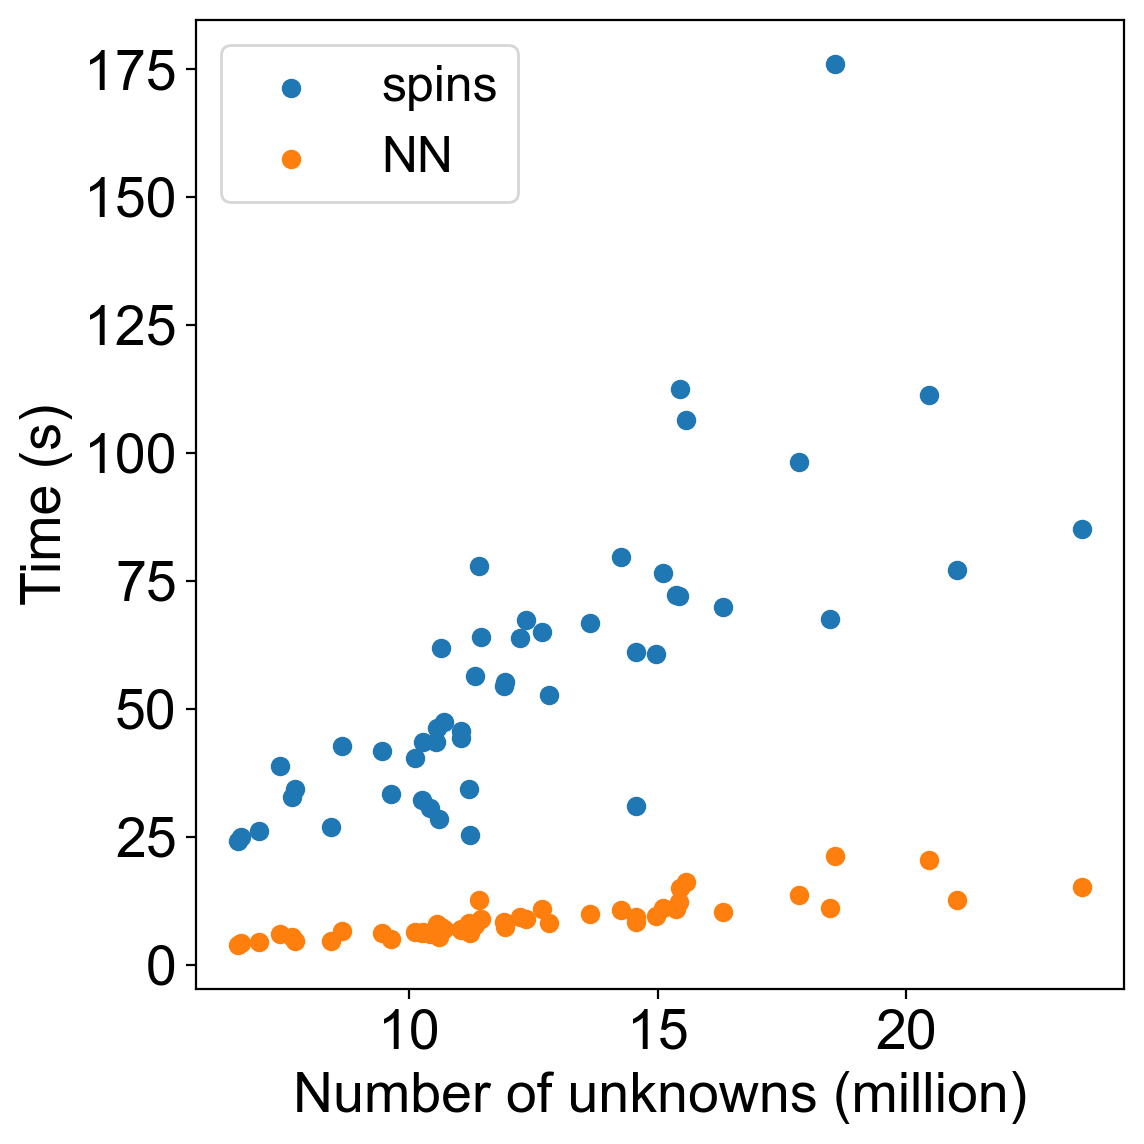

In [7]:
plt.rcParams.update({
    'font.size': 16,               # Default font size
    'font.sans-serif': ['Arial'],  # Specific font for sans-serif
    'axes.titlesize': 24,             # Font size for axes titles
    'axes.labelsize': 20,             # Font size for x and y labels
    'xtick.labelsize': 20,            # Font size for x-axis tick labels
    'ytick.labelsize': 20,            # Font size for y-axis tick labels
    'legend.fontsize': 18,            # Font size for legend
})

plt.figure(figsize=(6,6), dpi=200)
plt.scatter(voxels*3/4 / 1e6, spins_times, label="spins")
plt.scatter(voxels*3/4 / 1e6, NN_times, label="NN")
plt.xlabel("Number of unknowns (million)")
plt.ylabel("Time (s)")
plt.legend(loc="upper left")
plt.tight_layout()
plt.savefig("data/scaling.png", dpi=200)
print("average speed up: ", np.mean(spins_times/NN_times))

In [8]:
file_name = "data/voxels3.npy"
assert not os.path.isfile(file_name)
np.save(file_name, voxels)

In [9]:
file_name = "data/NN_times3.npy"
assert not os.path.isfile(file_name)
np.save(file_name, NN_times)

In [10]:
file_name = "data/spins_times3.npy"
assert not os.path.isfile(file_name)
np.save(file_name, spins_times)

In [2]:
voxels = np.concatenate([np.load("data/voxels1.npy"), np.load("data/voxels2.npy"), np.load("data/voxels3.npy")])
NN_times = np.concatenate([np.load("data/NN_times1.npy"), np.load("data/NN_times2.npy"), np.load("data/NN_times3.npy")])
spins_times = np.concatenate([np.load("data/spins_times1.npy"), np.load("data/spins_times2.npy"), np.load("data/spins_times3.npy")])